<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4352 non-null   object 
 1   close   4352 non-null   float64
 2   volume  4352 non-null   int64  
 3   open    4352 non-null   float64
 4   high    4352 non-null   float64
 5   low     4352 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 204.1+ KB


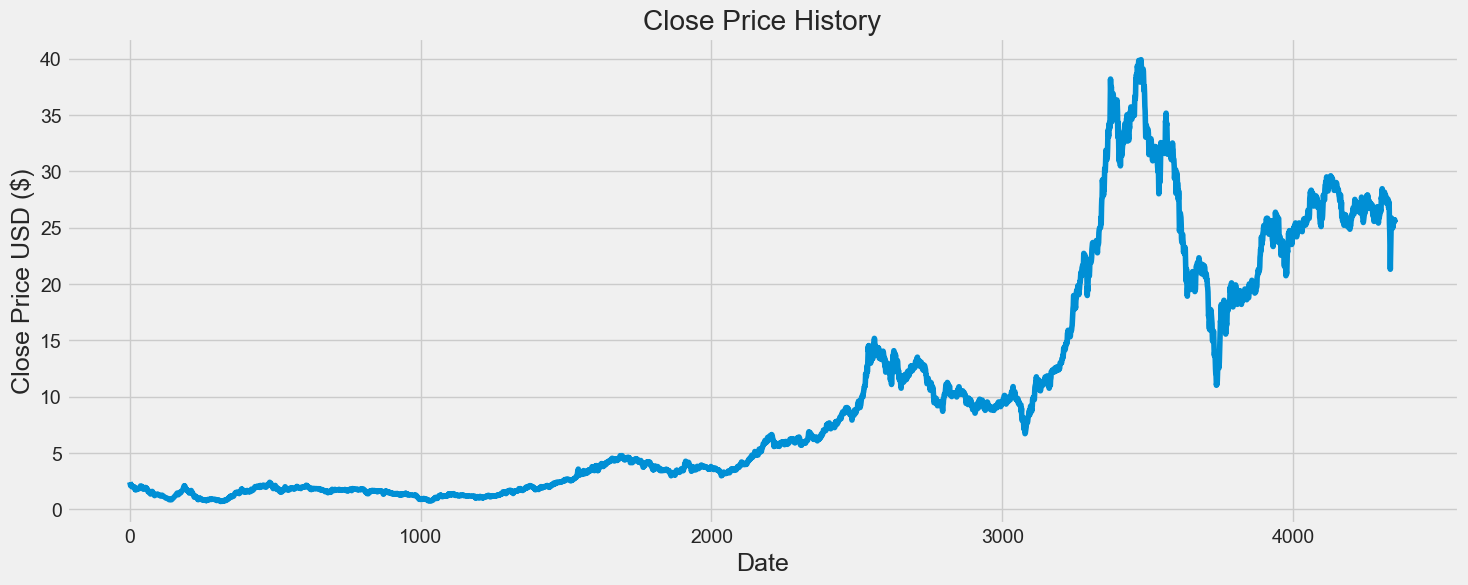

In [1]:
from datapreprocessing import *


# Nested CV - Day Forward Chaining

## Create dataset

In [5]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:

time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

In [7]:
x_for_train.shape

(4547, 30)

## Day forward chaining

In [8]:
def performXGBoost(X_train, Y_train, X_test, Y_test, parameters):

    XGBoost_model = XGBRegressor(n_estimators = parameters['n_estimators'], max_depth = parameters['max_depth'], learning_rate = parameters['learning_rate'])
    XGBoost_model.fit(X_train, Y_train, verbose=False)

    # Make predictions on the test set
    Y_pred_train = XGBoost_model.predict(X_train)
    Y_pred_test = XGBoost_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = XGBoost_model.score(X_train, Y_train)
    accuracy_valid = XGBoost_model.score(X_test, Y_test)
    
    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)
    
    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [9]:
from sklearn.model_selection import ParameterGrid

def performDayForwardChaining(X_train, y_train, number_folds):
    # define hyperparameters
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3,6,10],
        'learning_rate' : [0.01, 0.05, 0.1]
    }

    # convert hyperparameters to a list of parameters
    param_list = list(ParameterGrid(param_grid))
    
    print('Size train set: ', X_train.shape)
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: ', k)
    
    results_valid = []
    results_test = []
    # loop from the first 2 folds to the total number of folds    
    for i in range(3, number_folds + 1):
        print('')
        
        split = float(i-1)/i
        
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i))

        X = X_train[:(k*i),:]
        y = y_train[:(k*i),:]
        print('Size of train + valid + test: ', X.shape) 

        index = int(np.floor(X.shape[0] * split))
        print(index)
        # folds used to train the model        
        X_train_validFolds = X[:index,:]        
        y_train_validFolds = y[:index,:]
        
        index_valid = int((i-2)*index/(i-1))
        
        X_trainFolds = X_train_validFolds[:index_valid,:]
        y_trainFolds = y_train_validFolds[:index_valid,:]
        
        X_validFolds = X_train_validFolds[index_valid:,:]
        y_validFolds = y_train_validFolds[index_valid:,:]
        
        # fold used to test the model
        X_testFolds = X[(index + 1):,:]
        y_testFolds = y[(index + 1):,:]
        
        for j,params in enumerate(param_list):
            print(f"Evaluating parameters {j+1}: {params}")
            accuracies_valid = performXGBoost(X_trainFolds, y_trainFolds, X_validFolds, y_validFolds, params)
            
            results_valid.append({
            'parameters': params,
            'accuracy_train': accuracies_valid[0],
            'accuracy_valid': accuracies_valid[1],
            'mse_train': accuracies_valid[2],
            'mse_valid': accuracies_valid[3]
            })

        for result in results_valid:
            print("Parameters: ", result['parameters'])
            print("Train Accuracy: ", result['accuracy_train'])
            print("Valid Accuracy: ", result['accuracy_valid'])
            print("Train MSE: ", result['mse_train'])
            print("Valid MSE: ", result['mse_valid'])
            print("------------------------")
        
        # sort the results by 'accuracy_valid' in ascending order
        sorted_results_valid = sorted(results_valid, key=lambda x: x['mse_valid'], reverse=False)

        # get the first set of parameters from the sorted list
        best_parameters = sorted_results_valid[0]['parameters']
        print(best_parameters)
        
        accuracies_test = performXGBoost(X_train_validFolds, y_train_validFolds, X_testFolds, y_testFolds, best_parameters)
        
        results_test.append({
            'parameters': best_parameters,
            'accuracy_train': accuracies_test[0],
            'accuracy_test': accuracies_test[1],
            'mse_train': accuracies_test[2],
            'mse_test': accuracies_test[3]
            })
        
    acc_train_model = 0
    acc_test_model = 0
    mse_train_model = 0
    mse_test_model = 0
    cnt = 0
    for result in results_test:
        acc_train_model += result['accuracy_train']
        acc_test_model += result['accuracy_test']
        mse_train_model += result['mse_train']
        mse_test_model += result['mse_test']
        cnt += 1

    acc_train_model = acc_train_model/cnt
    acc_test_model = acc_test_model/cnt
    mse_train_model = mse_train_model/cnt
    mse_test_model = mse_test_model/cnt
    best_result = min(results_test, key=lambda x: (x['mse_train'], x['mse_test']))
    best_overall_params = best_result['parameters']
    # the function returns the mean of the accuracy on the n-1 folds    
    return acc_train_model, acc_test_model, mse_train_model, mse_test_model, best_overall_params

In [10]:
accuracy_train_model, accuracy_test_model, mse_train_model, mse_test_model, best_parameters = performDayForwardChaining(x_for_train, y_for_train, number_folds=5)

print("Train Accuracy Model: ", accuracy_train_model)
print("Test Accuracy Model: ", accuracy_test_model)
print("Train MSE Model: ", mse_train_model)
print("Test MSE Model: ", mse_test_model)
print("Best Overall Parameters: ", best_parameters)
print("------------------------")

Size train set:  (4547, 30)
Size of each fold:  909

Splitting the first 3 chunks at 2/3
Size of train + valid + test:  (2727, 30)
1818
Evaluating parameters 1: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Evaluating parameters 2: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Evaluating parameters 3: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Evaluating parameters 4: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Evaluating parameters 5: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
Evaluating parameters 6: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Evaluating parameters 7: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
Evaluating parameters 8: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Evaluating parameters 9: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Evaluating parameters 10: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10